# Parham's features
There are 5 layers in the model, each consecutive layer yields a longer feature vector than the last. Feature vector sizes for each layer are 20, 400, 800, 1600 and 3200.
<br>
The model's input is batches of 42 frames. No batches for the first 41 frames are created; therefore, only 1100 batches and 1100 corresponding feature vectors are generated.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_simgraph_05 as sg
import data_handler_03 as dh

# Load and group spike data
Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).
<br>
Group all 113 neurons. This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1
        
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


# Create training and validation datasets

In [4]:
def datapoint_parham(index, data_params):
    """
    Return a single datapoint consisting of (feature vector, label) 
    based on the extended index system of the whole dataset (297 repeats of a 1141-frame movie); 
    for example, the 6th frame of the 7th repeat is indexed 7*1141+5. 
    In this system, indices only move forward after repeats, so they represent time in a sense.
    Acceptable index range is batch_sz-1 to 1141*297-1.
      
    Inputs: index, data_params
    index - chosen datapoint's index
    data_params   -
        func - funtion which returns a datapoint (fv, lbl) based on its index
        features_dp - path to where feature vectors are stored
        spike_data - (297 x 1141 x m)-shaped array where m is the number of subgroups of neurons.
        group_id - index of the chosen subgroup of neurons which is being considered
        transform - func. applied to the original feature vector (defult: None, no transform is applied)
            
    
    Output: fv, lbl
    fv  - Dfx1 vector representing the selected time bin's feature vector
    lbl - the selected time bin's label
    """
    # unpack params
    features_dp = data_params['features_dp']
    lbl_func = data_params['lbl_func']
    transform = data_params['transform'] if 'transform' in data_params else None
    
    # feature vector
    # trial = index//1141
    frame = index%1141
    fvs = np.load(features_dp)
    fv = fvs[frame - 41]
    if transform is not None:
        fv = transform(fv)

    # label  
    lbls = lbl_func(data_params)
    lbl = lbls[index]
    
    return fv, lbl

In [31]:
def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::2]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

# data retrieval params - using layer1 features
data_params = {'func': datapoint_parham, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham2/features_test_2layer.npy', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': None, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1}

train_num = 50
val_num = 20

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=0)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
print('feature vector dim = {}'.format(train_data['des'].shape[1]))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  50 , val_num =  20
training data contains 25 points (50.00%) of label 1.
validation data contains 10 points (50.00%) of label 1.
feature vector dim = 400


# Learn the similarity graph

In [32]:
# reload sg package
import importlib
importlib.reload(sg)

<module 'my_simgraph_05' from '/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages/my_simgraph_05.py'>

In [86]:
# graph construction and penalty term parameters
sg_params = {'mu': 38.5, 'Dt': None, 'Dv':0, 'Dvt':2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': 0.01}

B, sg_stats = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=0)

Number of training datapoints: 50
Number of features for each point: 400
mu = 38.5
   0: eps = 1.56e-02;  train loss (E) = 16.96
   1: eps = 1.56e-02;  train loss (E) =  2.20
   2: eps = 2.44e-04;  train loss (E) =  1.40
   3: eps = 4.88e-04;  train loss (E) =  1.30
   4: eps = 9.77e-04;  train loss (E) =  1.11
   5: eps = 1.95e-03;  train loss (E) =  0.80
   6: eps = 3.91e-03;  train loss (E) =  0.39
   7: eps = 7.81e-03;  train loss (E) =  0.06
   8: eps = 3.91e-03;  train loss (E) =  0.03
   9: eps = 3.91e-03;  train loss (E) =  0.03


## Display learned metric matrix

Coordinates of elements with higher values than 3.706216088631619e-05


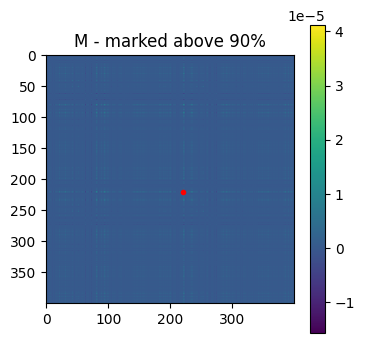

In [87]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, None)

# mark elements with high values
thresh = 90
lim = (thresh/100) * np.max(M) # marker threshold
f_sz = M.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M - marked above {}%'.format(thresh))
print('Coordinates of elements with higher values than {}'.format(lim))
# print(list(zip(xloc[M > lim],yloc[M > lim])))

# save results
# plt.savefig('../../../data/experiments/slowfast/slowfast_sg/temp/finalM_'+str(0)+'.png')
# plt.close()
# np.savetxt('results/sg_finalB.csv', B, delimiter=',')

# Validate the similarity graph

In [88]:
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']
M = B.T @ B
val_acc, y_est, t = sg.get_acc(M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=0, show_edges=False)

In [89]:
print('val acc = {:.2f}%'.format(val_acc*100))
print('elapsed time = {:.2f} ms'.format(t*1000))
print('estimated val labels = ', 2*(y_est>0).astype(np.int32)-1)

# # save results
# np.savetxt('results/sg_val_acc.txt', np.array([acc]))
# np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

val acc = 80.00%
elapsed time = 53.63 ms
estimated val labels =  [ 1  1 -1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1]


In [90]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes = val_loc[y_est > 0]

if sum(val_data['lbls']==1) == 0:
    missed = 0
else:
    missed = sum(np.logical_and(val_data['lbls']==1, y_est < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm = 0
else:
    false_alarm = sum(np.logical_and(val_data['lbls']==-1, y_est > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm*100))

Estimated spike time bins:  [ 0  1  3  4  5  6  7  8  9 10 12 17]
Real spike time bins:  [0 1 2 3 4 5 6 7 8 9]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 10.00%
False spikes (/all no-spike bins): 30.00%
